<a href="https://colab.research.google.com/github/filmerxyz/GarbageClassification/blob/master/Garbage_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Split Folders

In [1]:
!pip install split-folders

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import shutil
import os
from os.path import join

import split_folders

from garbage_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 32

LR = 3e-5

EPOCHS = 30

# Data

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/GarbageClassification_dataset

Cloning into 'GarbageClassification_dataset'...
remote: Enumerating objects: 2549, done.
remote: Counting objects: 100% (2549/2549), done.
remote: Compressing objects: 100% (2545/2545), done.
remote: Total 2549 (delta 4), reused 2548 (delta 3), pack-reused 0
Receiving objects: 100% (2549/2549), 40.45 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [6]:
mkdir_dir('/content/data_folder')

Directory  /content/data_folder  Created 


## Split

In [7]:
split_folders.ratio('/content/GarbageClassification_dataset/images', 
                    output='/content/data_folder', 
                    seed=1337, 
                    ratio=(0.63, 0.27, 0.10))

Copying files: 2527 files [00:00, 7402.83 files/s]


In [8]:
train_path = '/content/data_folder/train'
val_path = '/content/data_folder/val'
test_path = '/content/data_folder/test'

In [9]:
train_gen = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=0,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               horizontal_flip=True,
                               vertical_flip=True,)

val_gen = ImageDataGenerator(rescale=1. / 255)

test_gen = ImageDataGenerator(rescale=1. / 255)

In [10]:
train_datagen = train_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=train_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

val_datagen = val_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                          directory=val_path,
                                          shuffle=True,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode='categorical')

test_datagen = test_gen.flow_from_directory(batch_size=1,
                                          directory=test_path,
                                          shuffle=False,
                                          target_size=(IMG_WIDTH, IMG_HEIGHT), #(224,224)
                                          class_mode=None)

Found 1589 images belonging to 6 classes.
Found 679 images belonging to 6 classes.
Found 259 images belonging to 6 classes.


# Model

In [11]:
def build_model():
    base_model = tf.keras.applications.nasnet.NASNetMobile(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
    base_model.trainable = True

    average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(units=6, activation='softmax', name='prediction')(average_pooling_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    
    return model

In [12]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
19996672/19993432 [==============================] - 0s 0us/step


In [13]:
model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model_checkpoint = ModelCheckpoint(filepath='/content/garbage_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [33]:
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint],
                    verbose=1)

Epoch 1/30
50/50 [==============================] - 38s 766ms/step - loss: 0.0182 - accuracy: 0.9956 - val_loss: 0.4606 - val_accuracy: 0.8733
Epoch 2/30
50/50 [==============================] - 37s 745ms/step - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.4265 - val_accuracy: 0.8748
Epoch 3/30
50/50 [==============================] - 37s 742ms/step - loss: 0.0165 - accuracy: 0.9956 - val_loss: 0.4018 - val_accuracy: 0.8866
Epoch 4/30
50/50 [==============================] - 38s 762ms/step - loss: 0.0180 - accuracy: 0.9950 - val_loss: 0.3802 - val_accuracy: 0.8792
Epoch 5/30
50/50 [==============================] - 38s 750ms/step - loss: 0.0104 - accuracy: 0.9981 - val_loss: 0.3906 - val_accuracy: 0.8807
Epoch 6/30
50/50 [==============================] - 37s 743ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.3773 - val_accuracy: 0.8851
Epoch 7/30
50/50 [==============================] - 37s 742ms/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.3632 - val_accuracy: 0.8866

# Graph

## Accuracy

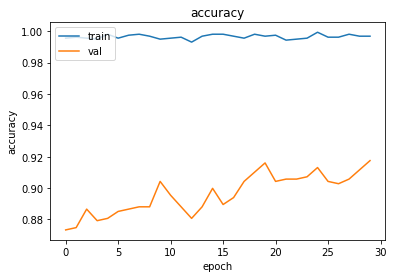

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

# Loss

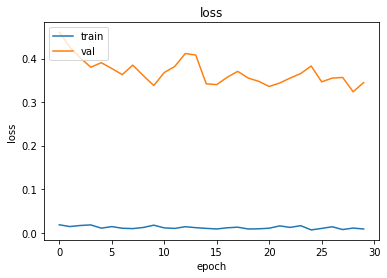

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [36]:
test_model = tf.keras.models.load_model('/content/garbage_model.h5')

In [37]:
test_labels = test_datagen.classes
predictions = test_model.predict(test_datagen, steps=test_datagen.samples, verbose=1)

# Confusion Matrix

In [38]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

cm_plot_labels = ['paper', 'cardboard', 'trash', 'metal', 'glass', 'plastic']

Confusion matrix, without normalization
[[34  0  0  7  0  1]
 [ 0 51  0  0  0  0]
 [ 0  2 37  1  2  0]
 [ 0  0  0 58  2  0]
 [ 0  5  1  1 41  1]
 [ 0  1  0  1  0 13]]


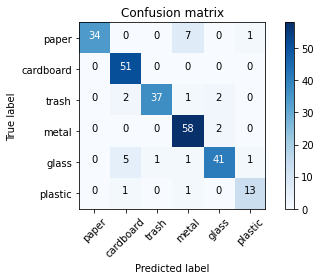

In [39]:
plot_confusion_matrix(cm, cm_plot_labels)

Normalized confusion matrix
[[0.80952381 0.         0.         0.16666667 0.         0.02380952]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.04761905 0.88095238 0.02380952 0.04761905 0.        ]
 [0.         0.         0.         0.96666667 0.03333333 0.        ]
 [0.         0.10204082 0.02040816 0.02040816 0.83673469 0.02040816]
 [0.         0.06666667 0.         0.06666667 0.         0.86666667]]


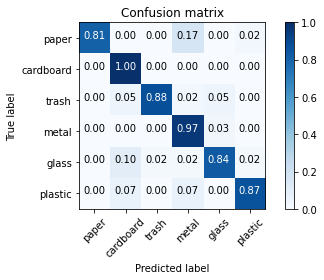

In [40]:
plot_confusion_matrix(cm, cm_plot_labels, True)

In [41]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=cm_plot_labels))

Confusion Matrix
[[34  0  0  7  0  1]
 [ 0 51  0  0  0  0]
 [ 0  2 37  1  2  0]
 [ 0  0  0 58  2  0]
 [ 0  5  1  1 41  1]
 [ 0  1  0  1  0 13]]
Classification Report
              precision    recall  f1-score   support

       paper       1.00      0.81      0.89        42
   cardboard       0.86      1.00      0.93        51
       trash       0.97      0.88      0.93        42
       metal       0.85      0.97      0.91        60
       glass       0.91      0.84      0.87        49
     plastic       0.87      0.87      0.87        15

    accuracy                           0.90       259
   macro avg       0.91      0.89      0.90       259
weighted avg       0.91      0.90      0.90       259

